This notebook is entirely based on https://www.tensorflow.org/tutorials/images/classification

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
random_seed = 3093453

batch_size = 256
img_height = 180
img_width = 180

In [3]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
data_dir = os.path.join(cwd, "dataset")
data_dir

'/Users/fynn/Projects/PokeDex/dataset'

In [4]:
# Before gif: 4421 files
# after Gif 135387
# After Downsampling: 18345
# One per gif: 6633
# with tcg: 20808
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=random_seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=random_seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20806 files belonging to 1006 classes.
Using 18726 files for training.


2024-04-10 08:52:27.663065: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-10 08:52:27.663094: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-10 08:52:27.663097: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-10 08:52:27.663326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-10 08:52:27.663352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 20806 files belonging to 1006 classes.
Using 2080 files for validation.


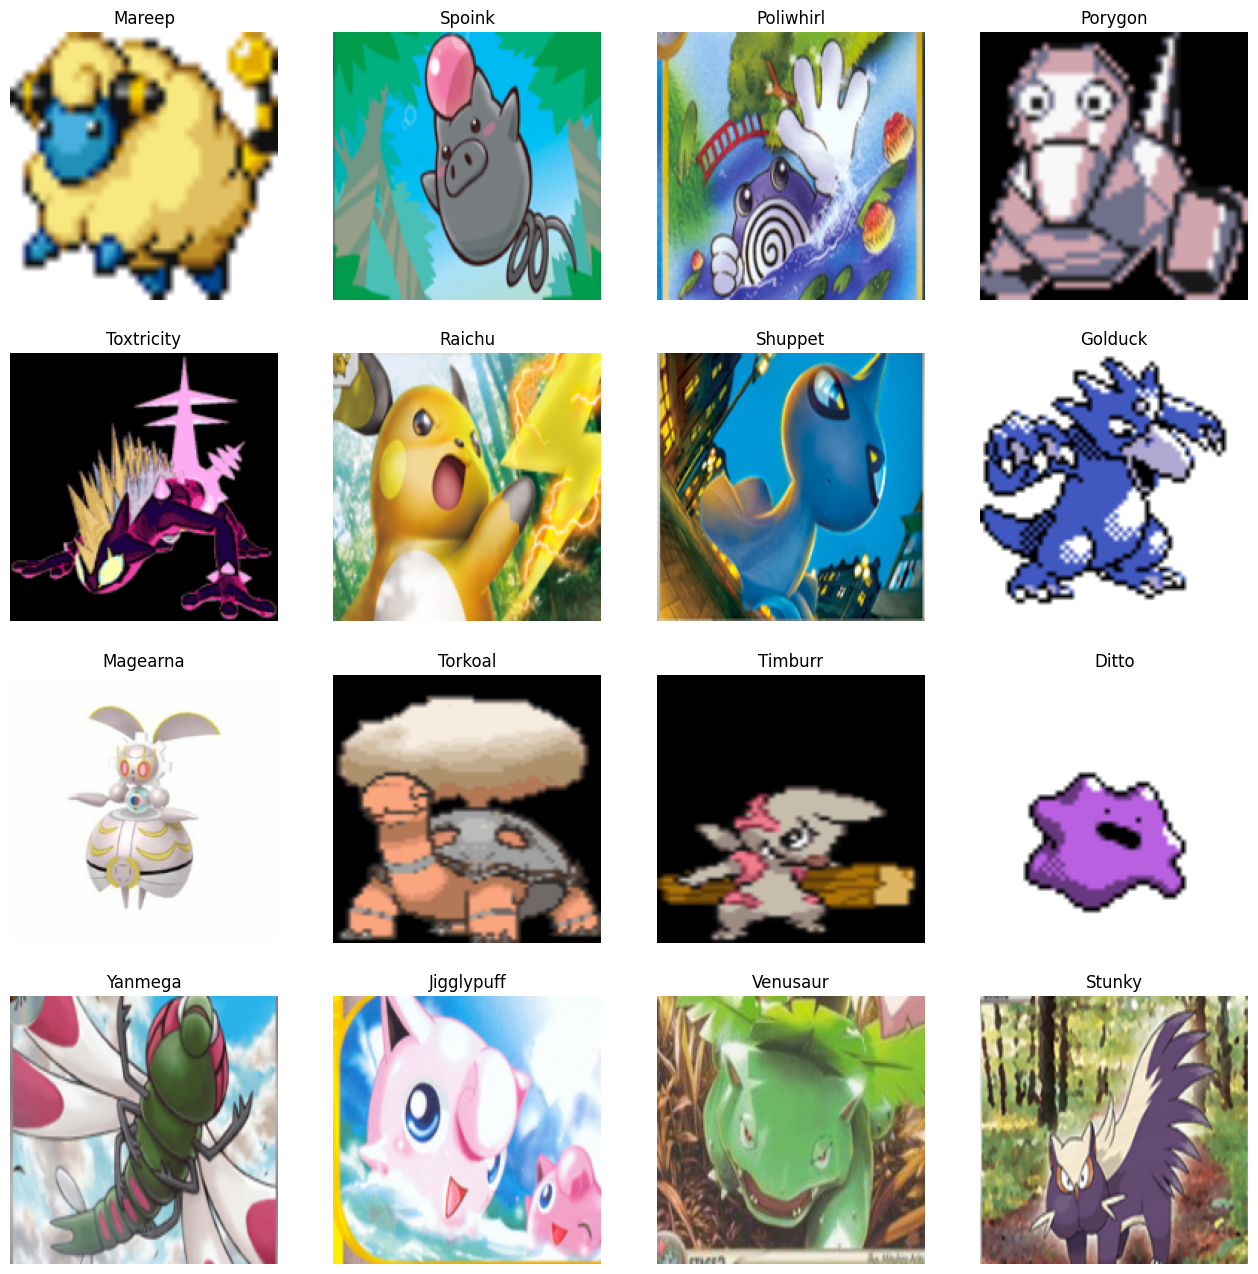

In [5]:
import matplotlib.pyplot as plt

class_names = np.array(train_ds.class_names)

plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [7]:
data_augmentation = keras.Sequential(
  [ 
    layers.RandomTranslation(0.05, 0.05, fill_mode="reflect"),
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.8),
    layers.GaussianNoise(20)
  ]
)

2024-04-10 08:52:31.389809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 08:52:32.839661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


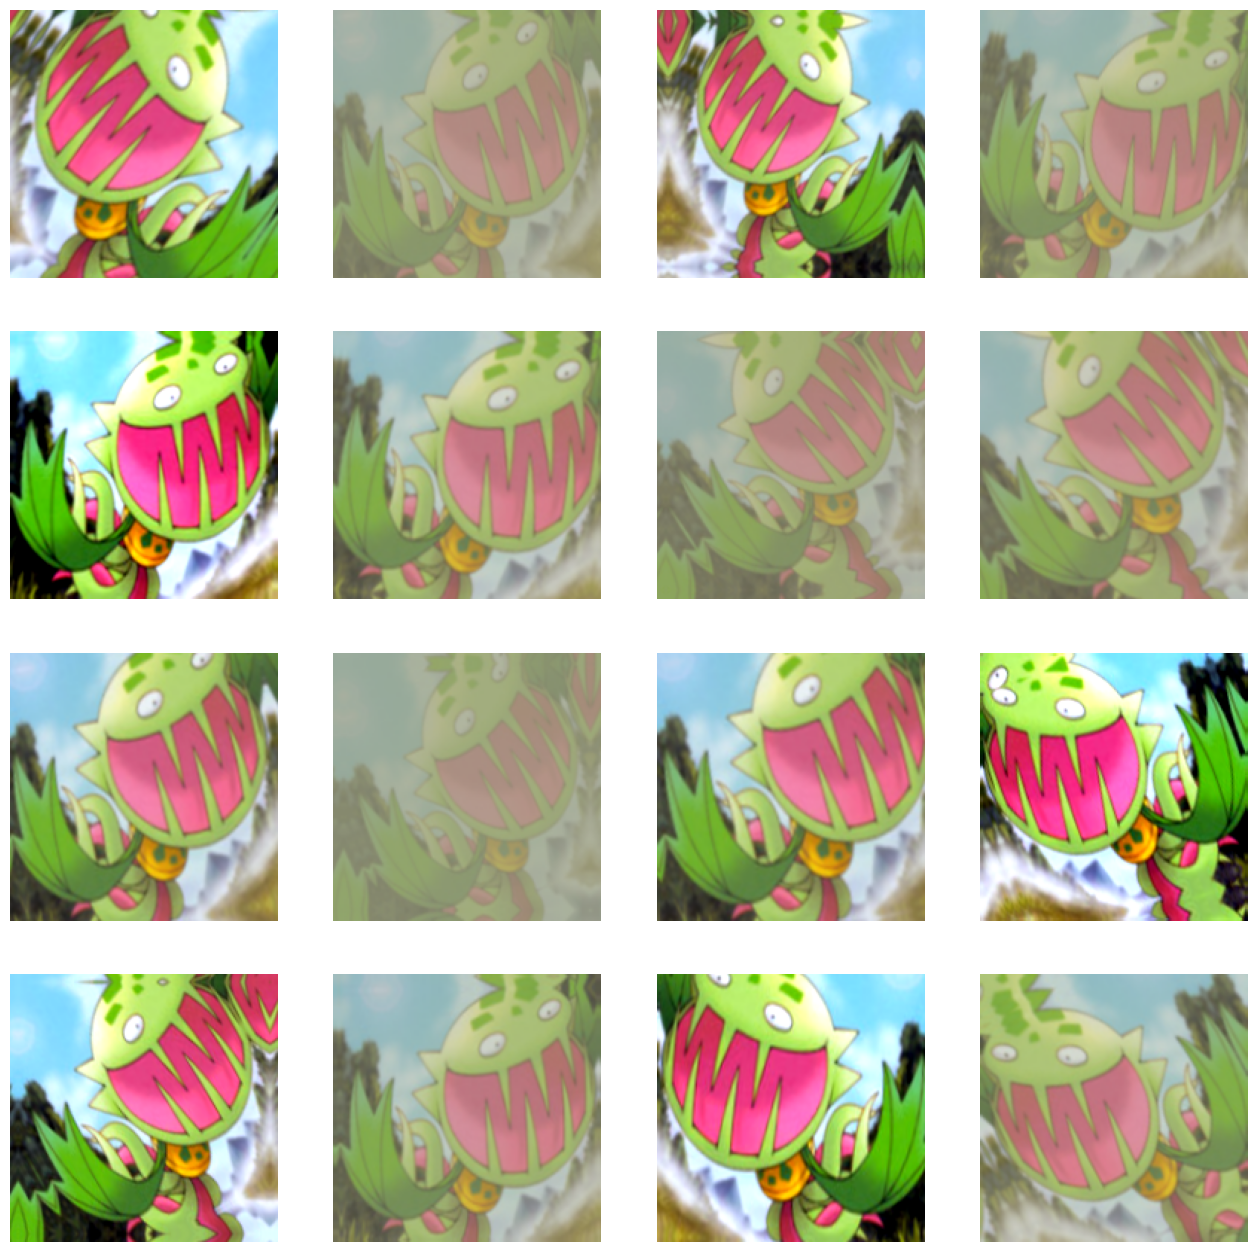

In [8]:
plt.figure(figsize=(16, 16))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

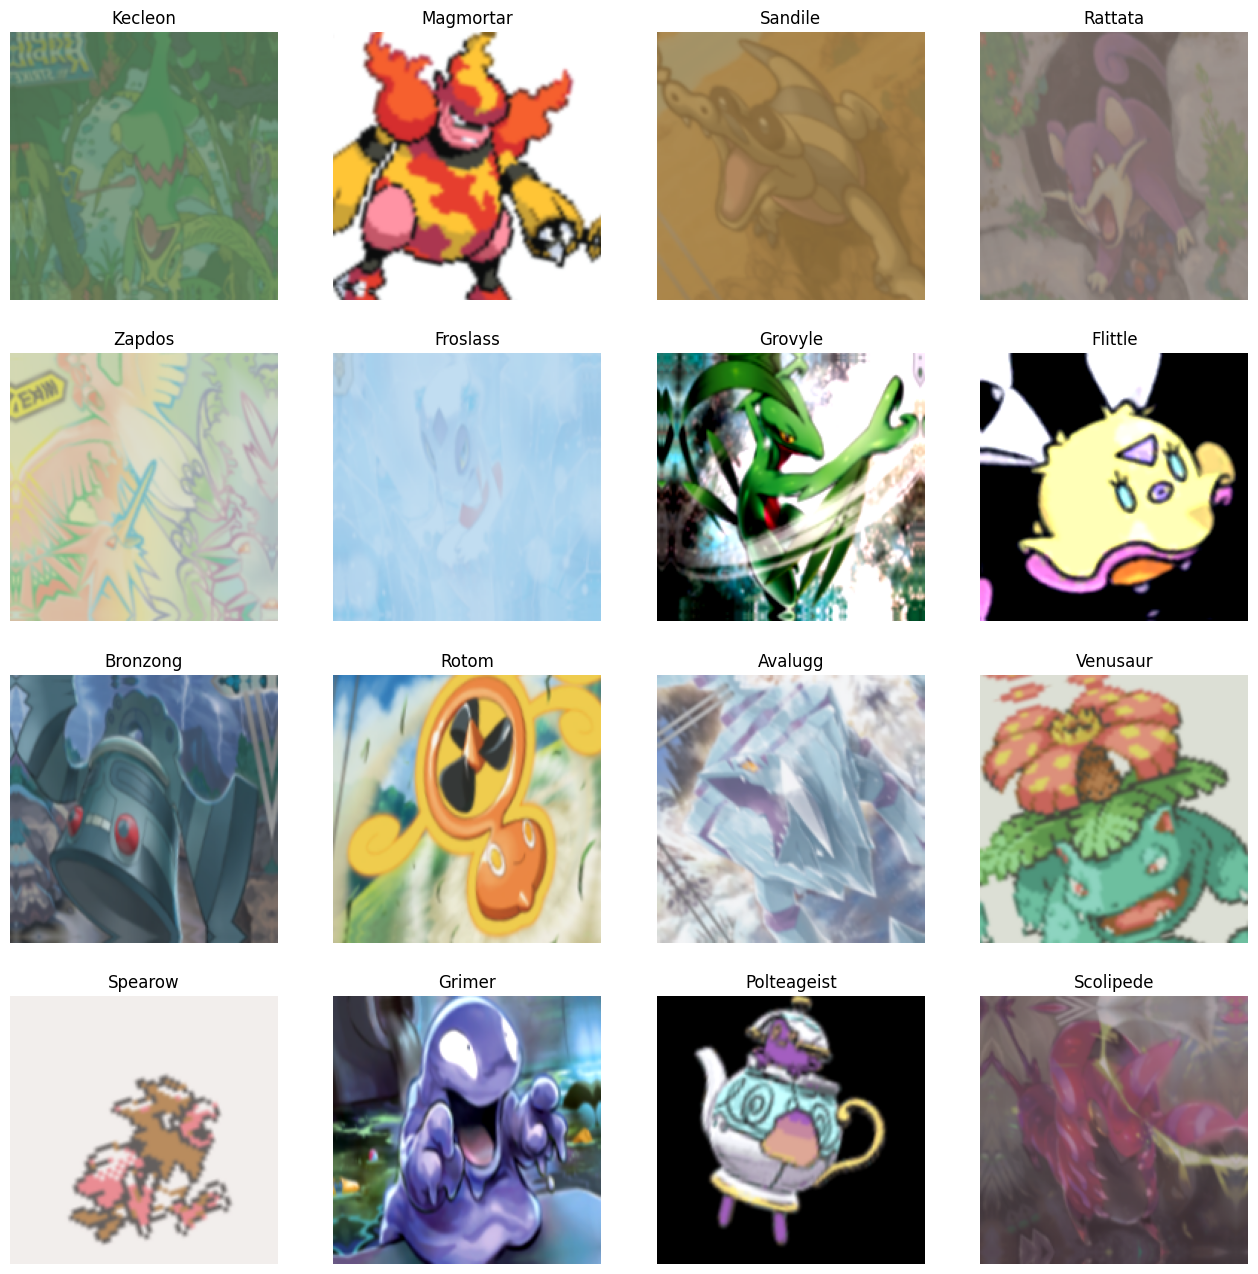

In [9]:
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Model

In [10]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='gelu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='gelu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='gelu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(264, activation='relu'),
  #layers.MultiHeadAttention(16, 8),
  layers.Dropout(0.2),
  layers.Dense(num_classes,
               #activation="softmax",
               name="outputs"),
])

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

patience = 5

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=patience/3,
    verbose=1,
)

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss =tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True),
              metrics=['accuracy', ])

In [12]:
epochs = 1000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping, lr_scheduler]
)

Epoch 1/1000


2024-04-10 08:52:45.107369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 52s 625ms/step - loss: 6.6752 - accuracy: 0.0104 - val_loss: 6.4126 - val_accuracy: 0.0163 - lr: 0.0010
Epoch 2/1000
74/74 [==============================] - 48s 643ms/step - loss: 6.1551 - accuracy: 0.0236 - val_loss: 5.9059 - val_accuracy: 0.0346 - lr: 0.0010
Epoch 3/1000
74/74 [==============================] - 47s 641ms/step - loss: 5.6281 - accuracy: 0.0525 - val_loss: 5.6757 - val_accuracy: 0.0538 - lr: 0.0010
Epoch 4/1000
74/74 [==============================] - 47s 629ms/step - loss: 5.3270 - accuracy: 0.0848 - val_loss: 5.8960 - val_accuracy: 0.0726 - lr: 0.0010
Epoch 5/1000
74/74 [==============================] - ETA: 0s - loss: 5.1765 - accuracy: 0.1309
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
74/74 [==============================] - 47s 643ms/step - loss: 5.1765 - accuracy: 0.1309 - val_loss: 5.9779 - val_accuracy: 0.0808 - lr: 0.0010
Epoch 6/1000
74/74 [==============================] - 47s 633ms/

<Axes: >

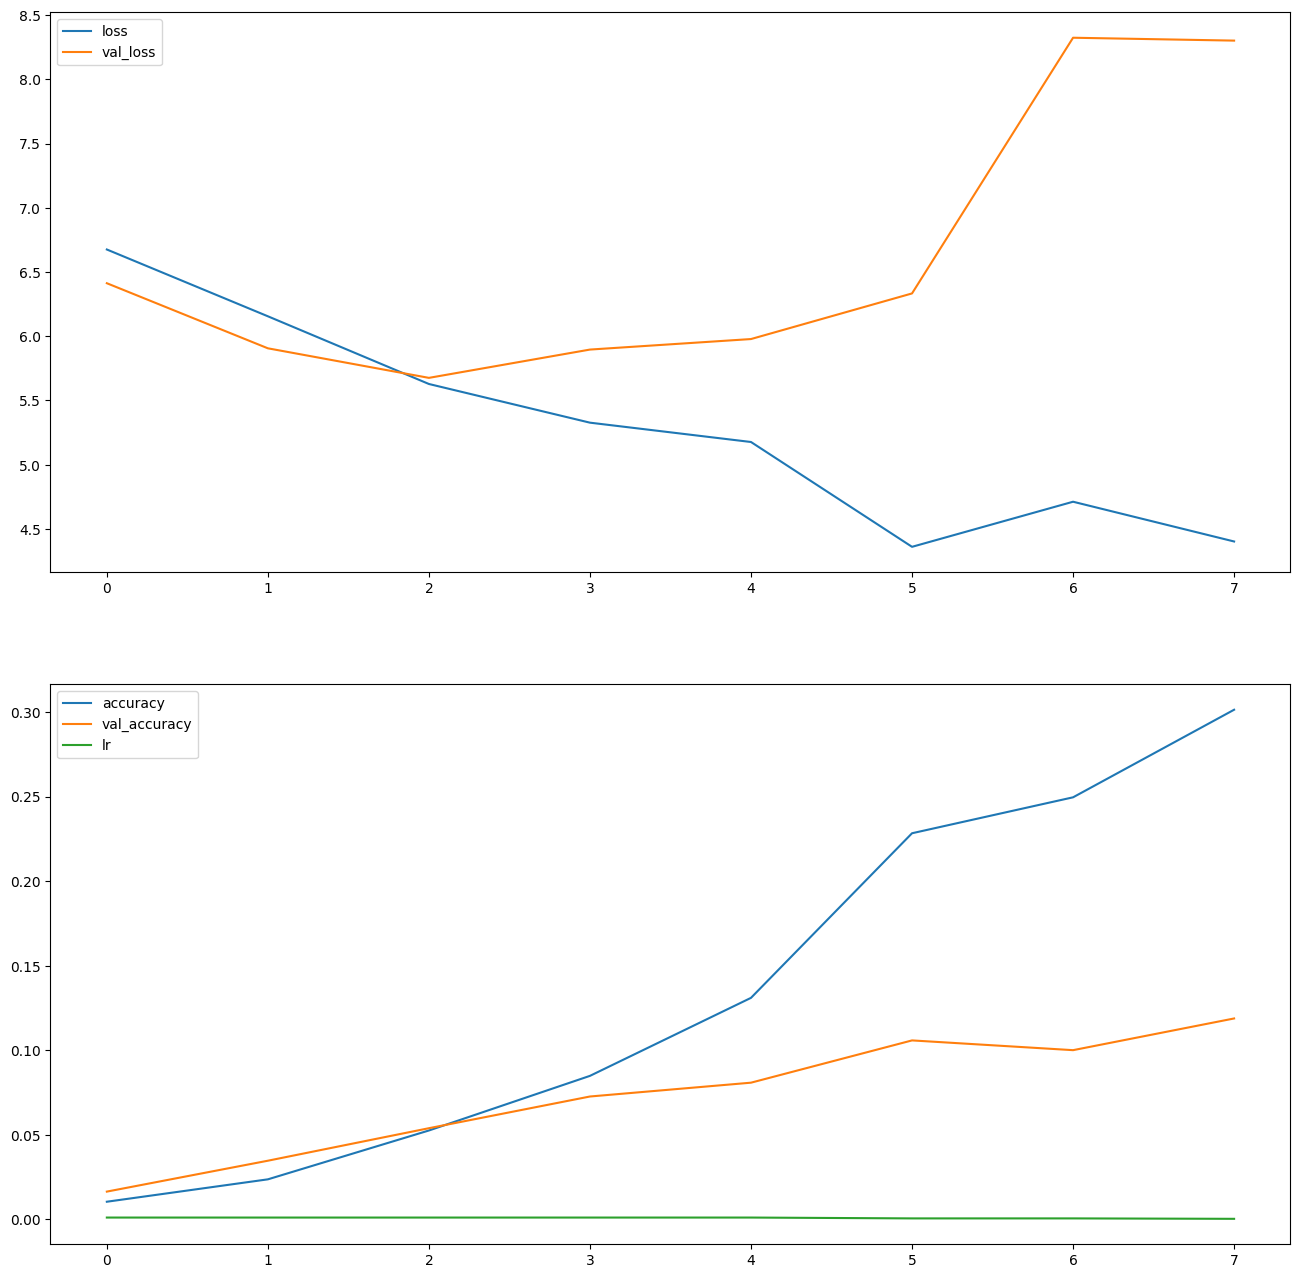

In [13]:
import pandas as pd

df = pd.DataFrame(history.history)

fig, ax = plt.subplots(2, figsize=(16, 16))
df.loc[:,df.columns.str.contains("loss")].plot(ax=ax[0])
df.loc[:,~df.columns.str.contains("loss")].plot(ax=ax[1])

# Predict on new data:

In [14]:
img_path = "/Users/fynn/Desktop/Bildschirmfoto 2023-10-12 um 14.00.48.png" # charizard
img_path = "/Users/fynn/Desktop/stat-charizard.png"
#img_path ="/Users/fynn/Desktop/Bildschirmfoto 2023-10-12 um 17.43.15.png" # pikachu
#img_path ="/Users/fynn/Desktop/Bildschirmfoto 2023-10-12 um 17.44.12.png" # charizard mega X

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

/Users/fynn/Projects/PokeDex/.venv/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 340ms/step
This image most likely belongs to Hariyama with a 52.50 percent confidence.


In [15]:
class_names[np.argsort(score)][::-1][:10]

array(['Hariyama', 'Tepig', 'Panpour', 'Pumpkaboo', 'Numel', 'Wormadam',
       'Charizard', 'Pikachu', 'Mudkip', 'Heliolisk'], dtype='<U12')

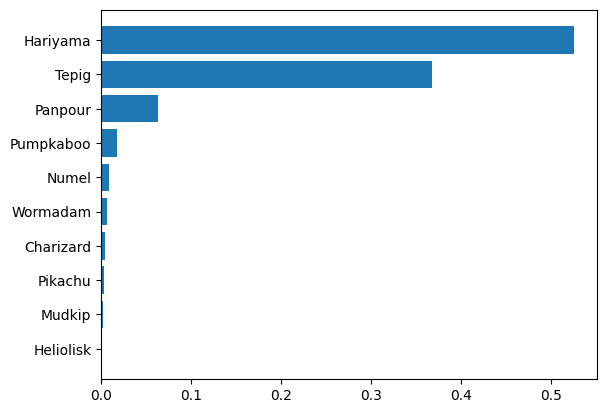

In [16]:
plt.barh(class_names[np.argsort(score)][-10:], np.sort(score)[-10:]);